The MIT License (MIT)

Copyright (c) 2018 Lisong Guo <lisong.guo@me.com>

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


### Abstract

This notebook is intended to showcase how to use the MNL (Multinomial Logistic Regression) model to predict the booking probability for each option within a session.

One can find the sample training and testing data under the `data` folder.

In [18]:
# import the model and all the auxiliary functions
from MNL import *
from MNL_plus import *
from Mint import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
import numpy as np

import pprint 
pp = pprint.PrettyPrinter(indent=4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

Num features: 17
{'loss': 'BinaryCrossEntropy', 'optimizer': 'Adam', 'learning_rate': 0.001, 'momentum': 0, 'weight_decay': 0, 'epochs': 20, 'early_stop_min_delta': 0.0001, 'patience': 5, 'gpu': True, 'verbose': 1, 'l1_loss_weight': 0, 'l2_loss_weight': 0, 'save_gradients': False, 'MNL_features': ['deptime_inbound_cos2p', 'deptime_inbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'price_elasticity', 'reco_contains_CX', 'reco_contains_MH', 'reco_contains_OD', 'reco_contains_PG', 'reco_contains_SQ', 'reco_contains_TG', 'reco_contains_VN', 'rescaled_reco_eft']}
epoch: 0  loss: 257.14750691641086 best_loss: 1000000000000000.0
epoch: 1  loss: 181.9527746155091 best_loss: 257.14750691641086
epoch: 2  loss: 179.82489137096906 best_loss: 181.9527746155091
epoch: 3  loss: 178.99131734003572 best_loss: 179.82489137096906
epoch: 4  loss: 178.5198961016953 best_loss: 178.99131734

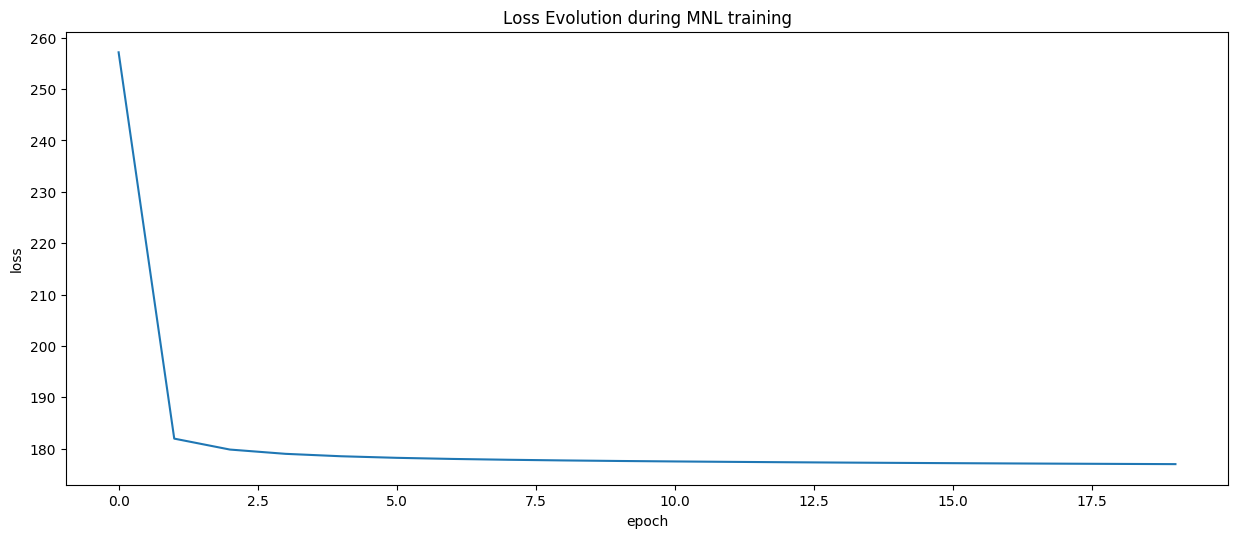

In [16]:

TRAIN_CONFIG = {
    #'MNL_features': MNL_features,
    
    # when absent, by default, use all the features within the training data
    #'MNL_features': MNL_features,
    
    # options: BinaryCrossEntropy, MaxLogLikelihood
    #'loss':  'MaxLogLikelihood',
    'loss':  'BinaryCrossEntropy',
    
    'optimizer': 'Adam',  # options:  Adam, RMSprop, SGD, LBFGS.
    # Adam would converge much faster
    # LBFGS is a very memory intensive optimizer (it requires additional param_bytes * (history_size + 1) bytes).
    # If it doesn’t fit in memory try reducing the history size, or use a different algorithm.
    # By default, history_size == 100
    'learning_rate': 1e-3, # Applicable to Adam, SGD, and LBFGS
    # The learning_rate parameter seems essential to LBFGS, which converges in two epochs.
    #  So far, learning_rate == 0.1 seems to be ok for LBFGS
    
    #'momentum': 0.9,  # applicable to SGD, RMSprop
    'momentum': 0,  # applicable to SGD, RMSprop
    
    # The resulting model seems to be more balanced, i.e. no extreme large/small weights,
    #  although one might not have the most ideal performance, i.e. high top_5_rank etc.
    'weight_decay': 0, # Applicable to Adam, RMSprop and SGD
    
    'epochs': 20,
    'early_stop_min_delta': 1e-4,
    'patience': 5,
    
    'gpu': True,  # luckily, running on GPU is faster than CPU in this case.
    
    # level of logging, 0: no log,  1: print epoch related logs;  2: print session related logs
    'verbose': 1,
    
    # Adding the regularization degredates the performance of model
    #   which might suggests that the model is still underfitting, not overfitting.
    'l1_loss_weight': 0,  # e.g. 0.001 the regularization that would marginalize the weights
    'l2_loss_weight': 0,
    
    # flag indicates whether to save gradients during the training
    'save_gradients': False
}


# set random seed for reproduceability
np.random.seed(17)
torch.manual_seed(17)

df_train = pd.read_csv('data/train_SINBKK_RT_B.csv')

# Create a brand-new model
model_tuple, loss_list = run_training(df_train, TRAIN_CONFIG)

# Continue training on the existing model
#model_tuple, loss_list = run_training(df_mlogit, TRAIN_CONFIG, model_tuple)


# unzip the tuple
(model, loss, optimizer) = model_tuple


# plot the evolution of loss
plot_loss(loss_list)



In [12]:
model.get_feature_weights()

{'deptime_inbound_cos2p': -0.36398515004923043,
 'deptime_inbound_cos4p': -0.26577859957974848,
 'deptime_inbound_sin2p': -1.213463410585474,
 'deptime_inbound_sin4p': -0.31855167737229889,
 'deptime_outbound_cos2p': -0.93981497101512435,
 'deptime_outbound_cos4p': -0.051423086136082735,
 'deptime_outbound_sin2p': 0.25456406778561269,
 'deptime_outbound_sin4p': -0.54952845899020164,
 'price_elasticity': 0.0010554576044143206,
 'reco_contains_CX': 0.89406695640341571,
 'reco_contains_MH': -1.6215626453096521,
 'reco_contains_OD': -0.90218537192269455,
 'reco_contains_PG': -9.9075223796943561,
 'reco_contains_SQ': 0.47816781886072446,
 'reco_contains_TG': 0.20804998174678926,
 'reco_contains_VN': -0.79540231827491503,
 'rescaled_reco_eft': -0.96404073093394504}

### Model Validation

In this section, we test the trained model and calculate some performance benchmarks.

In [5]:
df_test = pd.read_csv('data/test_SINBKK_RT_B.csv')

test_results = test_model(model, df_test, TRAIN_CONFIG)

test_results.head()

Num of testing sessions: 542


,session_id,alter_id,choice,price_elasticity,rescaled_reco_eft,reco_contains_MH,reco_contains_TG,reco_contains_PG,reco_contains_SQ,reco_contains_VN,...,reco_contains_OD,deptime_outbound_sin2p,deptime_outbound_sin4p,deptime_outbound_cos2p,deptime_outbound_cos4p,deptime_inbound_sin2p,deptime_inbound_sin4p,deptime_inbound_cos2p,deptime_inbound_cos4p,pred_value
1617,170326817,0,1,248.6,0.0,0,1,0,0,0,...,0,0.906308,-0.766044,-0.422618,-0.642788,-0.906308,-0.766044,0.422618,-0.642788,0.144099
1618,170326817,1,0,217.6,0.0,0,1,0,0,0,...,0,-0.108867,0.216439,-0.994056,0.976296,0.195090,-0.382683,-0.980785,0.923880,0.025255
1619,170326817,2,0,217.6,0.0,0,1,0,0,0,...,0,-0.854912,0.887011,-0.518773,-0.461748,0.195090,-0.382683,-0.980785,0.923880,0.009953
1620,170326817,3,0,233.6,0.0,0,1,0,0,0,...,0,0.906308,-0.766044,-0.422618,-0.642788,0.195090,-0.382683,-0.980785,0.923880,0.036251
1621,170326817,4,0,233.6,0.0,0,1,0,0,0,...,0,-0.108867,0.216439,-0.994056,0.976296,-0.461749,0.819152,-0.887011,0.573576,0.041227


In [105]:
# Test the model with the testing data
# Calculate the probability and the trank of the chosen alternative
test_stats = validate(model, df_test, TRAIN_CONFIG)

test_stats.head()

Num of testing sessions: 542


,session_id,session_size,rank_of_chosen_one,prob_of_chosen_one,max_prob
0,1702036,36,15.0,0.025779,0.133754
1,1704193,60,9.0,0.033080,0.102809
2,17033132,60,1.0,0.266916,0.266916
3,17041139,60,5.0,0.074934,0.247137
4,17042962,60,11.0,0.037114,0.093615


Summarize the testing results into a list of KPIs, such as:

- *mean_probability*: the average probability of the predicted alternative among all sessions


- *top_5_rank_quantile*: the percentile of sessions where the probability of the predicted alternative is among the top 5.


- *AIC*: Akaike Information Criterion, which offers an estimate of the relative information lost when a given model is used to represent the process that generated the data.

In [106]:
summarize_KPIs(test_stats, len(TRAIN_CONFIG['MNL_features']))

{'AIC': 3144.4564680427138,
 'log_likelihood': -1555.2282340213569,
 'mean_log_likelihood': -2.8694247860172637,
 'mean_probability': 0.097970350765488143,
 'mean_probability_diff': -0.081118023405807912,
 'mean_rank': 8.5129151291512919,
 'mean_rank_ratio': 0.17820222487861498,
 'mean_session_size': 54.702952029520297,
 'median_probability': 0.06263184576785641,
 'median_probability_diff': -0.08119854629309217,
 'median_rank': 5.0,
 'median_rank_ratio': 0.1,
 'session_num': 542,
 'top_10_rank_quantile': 72.693726937269375,
 'top_1_rank_quantile': 17.343173431734318,
 'top_5_rank_quantile': 51.660516605166052}

### Model Deployment

In this section, we show some examples on how to use the APIs to serialize the model and eventually deploy it in the production environment. 

In [38]:
# Transfer the trained model to a minimized model for later inference.

model_to_deploy = Mint(TRAIN_CONFIG['MNL_features'], model.get_feature_weights())

model_to_deploy.get_feature_weights()

{'deptime_inbound_cos2p': -0.36398515004923043,
 'deptime_inbound_cos4p': -0.26577859957974848,
 'deptime_inbound_sin2p': -1.213463410585474,
 'deptime_inbound_sin4p': -0.31855167737229889,
 'deptime_outbound_cos2p': -0.93981497101512435,
 'deptime_outbound_cos4p': -0.051423086136082735,
 'deptime_outbound_sin2p': 0.25456406778561269,
 'deptime_outbound_sin4p': -0.54952845899020164,
 'price_elasticity': 0.0010554576044143206,
 'reco_contains_CX': 0.89406695640341571,
 'reco_contains_MH': -1.6215626453096521,
 'reco_contains_OD': -0.90218537192269455,
 'reco_contains_PG': -9.9075223796943561,
 'reco_contains_SQ': 0.47816781886072446,
 'reco_contains_TG': 0.20804998174678926,
 'reco_contains_VN': -0.79540231827491503,
 'rescaled_reco_eft': -0.96404073093394504}

In [21]:
# Dump/Pickle the model object into a binary file.
model_to_deploy.save('model/mint_model.pkl')

save model to  model/mint_model.pkl


In [33]:
# instantialize a new model from the pickle file
inference_model = load_model('model/mint_model.pkl')

load model from  model/mint_model.pkl


In [39]:
# Sample a session for test
sample_session = df_test[df_test['session_id'] == 170326817]
test_X = sample_session[TRAIN_CONFIG['MNL_features']]
test_X.head()

,deptime_inbound_cos2p,deptime_inbound_cos4p,deptime_inbound_sin2p,deptime_inbound_sin4p,deptime_outbound_cos2p,deptime_outbound_cos4p,deptime_outbound_sin2p,deptime_outbound_sin4p,price_elasticity,reco_contains_CX,reco_contains_MH,reco_contains_OD,reco_contains_PG,reco_contains_SQ,reco_contains_TG,reco_contains_VN,rescaled_reco_eft
1617,0.422618,-0.642788,-0.906308,-0.766044,-0.422618,-0.642788,0.906308,-0.766044,248.6,0,0,0,0,0,1,0,0.0
1618,-0.980785,0.923880,0.195090,-0.382683,-0.994056,0.976296,-0.108867,0.216439,217.6,0,0,0,0,0,1,0,0.0
1619,-0.980785,0.923880,0.195090,-0.382683,-0.518773,-0.461748,-0.854912,0.887011,217.6,0,0,0,0,0,1,0,0.0
1620,-0.980785,0.923880,0.195090,-0.382683,-0.422618,-0.642788,0.906308,-0.766044,233.6,0,0,0,0,0,1,0,0.0
1621,-0.887011,0.573576,-0.461749,0.819152,-0.994056,0.976296,-0.108867,0.216439,233.6,0,0,0,0,0,1,0,0.0


In [40]:
# Compare the results given by the original model with Pytorch and
#   the inference model without pytorch. 

# Note: there are some subtle differences which should be due to the fact
#   that the precision provided by Pytorch and Pandas/Numpy libraries is different.
inference_model.predict(test_X) - model.predict(test_X).reshape(-1)

array([ -5.55111512e-17,  -1.38777878e-17,  -1.73472348e-18,
        -1.38777878e-17,  -1.38777878e-17,  -2.77555756e-17,
        -3.46944695e-18,  -1.38777878e-17,  -1.38777878e-17,
        -3.46944695e-18,   1.73472348e-18,   2.77555756e-17,
         0.00000000e+00,  -1.73472348e-18,  -3.46944695e-18,
        -6.93889390e-18,  -5.55111512e-17,  -3.46944695e-18,
        -1.38777878e-17,  -3.46944695e-18,   0.00000000e+00,
        -1.03397577e-25,  -1.61558713e-27,  -3.78653235e-29,
        -1.73472348e-18,  -1.73472348e-18,  -6.93889390e-18,
        -6.93889390e-18,  -8.27180613e-25,  -6.46234854e-27,
        -5.04870979e-29,  -3.38813179e-21,  -6.77626358e-21,
        -6.77626358e-21,  -1.01643954e-20,  -3.38813179e-21,
        -1.69406589e-21,  -6.77626358e-21,  -1.69406589e-21,
        -1.01643954e-20,  -1.69406589e-21,  -6.77626358e-21,
        -1.69406589e-21,  -6.77626358e-21,  -8.47032947e-22,
        -3.38813179e-21,  -3.38813179e-21,  -8.47032947e-22,
        -3.38813179e-21,